# WORKFLOW for the creation of the ML potentials at Constant Potential

Requirements:

- "Franken" => training and testing of the ML potential
- "LAMMPS" => MD
- "DEAL" python suite + "FLARE" => selection of new configurations
- "VASP" (or alternatively a DFT code) => single-point calculations for the labelling of the configurations 
- "DoubleRefernceMethod" python suite => handling of the DFT workflow

Sequence of STEPS:

0. **STEP 0**: Development of a PZC model (alternatively a pre-trained general-purpose model can be employed) => see notebook "Workflow_PZC.ipynb" 
1. **STEP 1**: Training via Transfer Learning
2. **STEP 2**: Explorative MD simulation with LAMMPS
3. **STEP 3**: "DEAL" selection of new configurations
4. **STEP 4**: Single-point calculations for the labelling of the configurations at constant potential

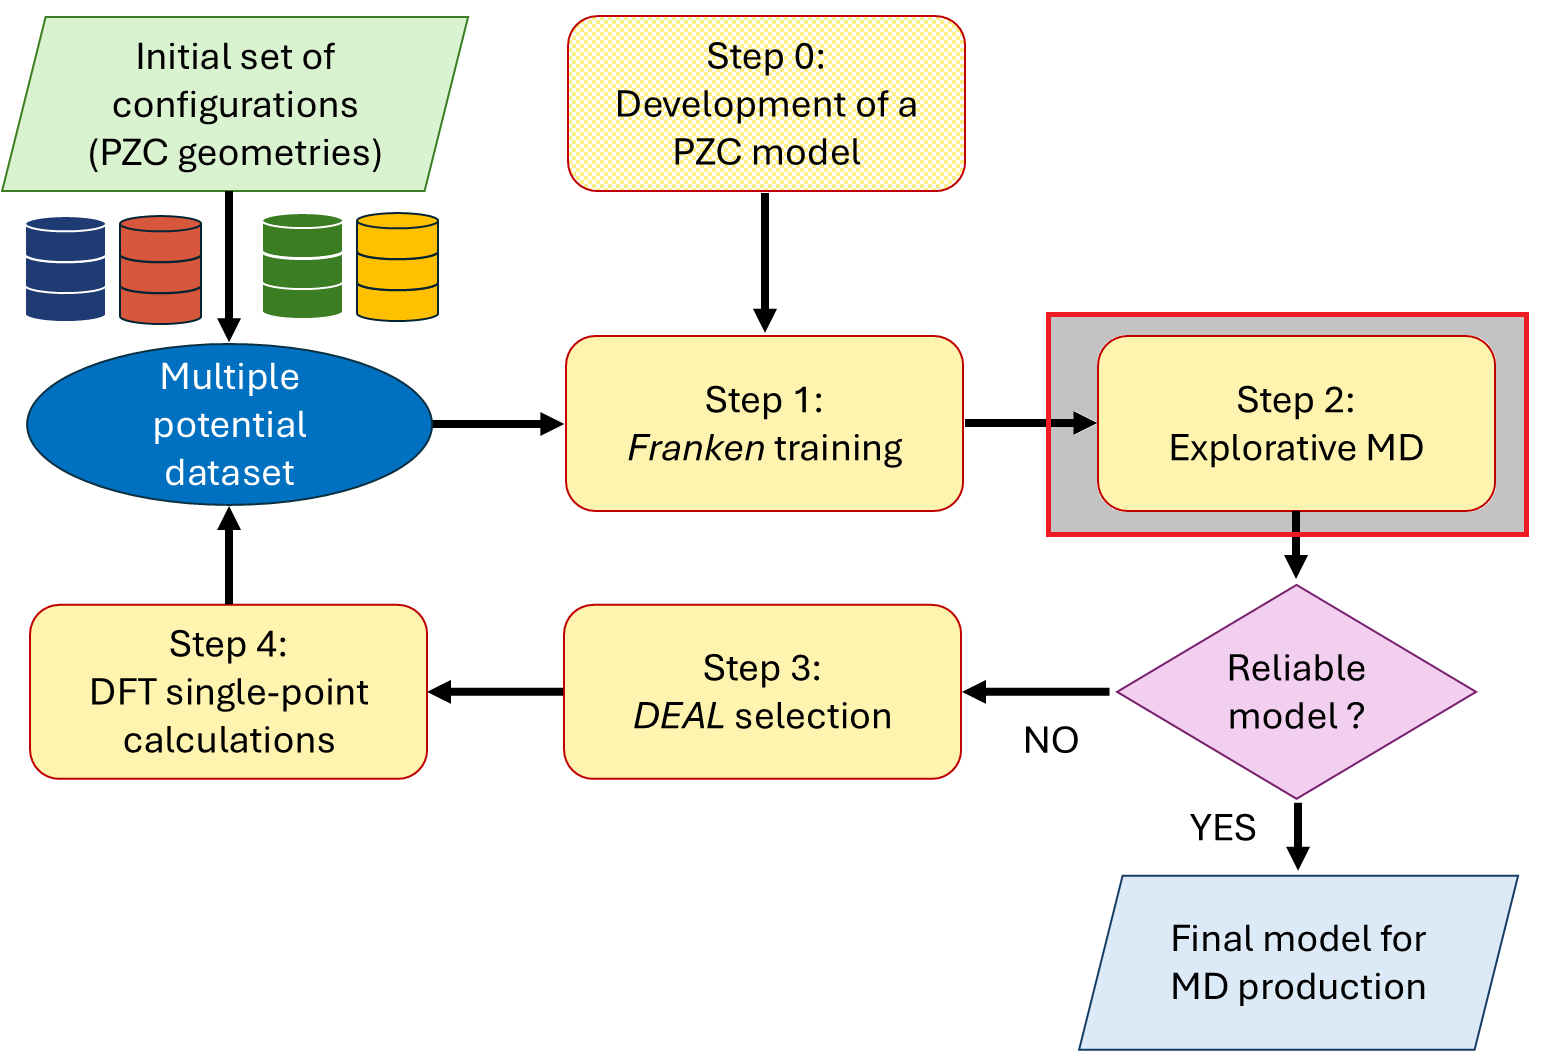

In [1]:
from IPython.display import Image
Image(filename='MD/CP_workflow_general_step2.png',width=700, height=600)

These steps should be repeated until the generated ML potentials are sufficiently reliable, i.e.:
- they allow for stable MD simulations
- they are accurate
- they grant converged physical properties (e.g., solvent density profile)

Here we focus on **STEP 2** => Explorative MD simulation with LAMMPS

In [8]:
# Imports:
import numpy as np
import sys
import os
import glob
import shutil
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import json
from datetime import datetime
from natsort import natsorted

from ase import Atom
from ase.io import read,write

# Path to the workflow_utils directory
# !!! MODIFY IF NEEDED !!!
workflow_utils_path = "../"
sys.path.append(workflow_utils_path)

In [3]:
# SPECIFY the values of target potentials to be used in the calculations
V_vector = [-0.5,-0.75,-1.0,-1.25,-1.5,-1.75,-2.0]
V_vector = np.array(V_vector)

print("Target potentials (V vs SHE) to be used in the calculations:\n",V_vector)

from workflow_utils.python_utils import convert_V_to_label

V_vector_labels=convert_V_to_label(V_vector)

print("Corresponding labels for the target potentials:\n",V_vector_labels)

Target potentials (V vs SHE) to be used in the calculations:
 [-0.5  -0.75 -1.   -1.25 -1.5  -1.75 -2.  ]
Corresponding labels for the target potentials:
 ['m05', 'm075', 'm1', 'm125', 'm15', 'm175', 'm2']


In [4]:
# Choose the random feature values used for the different potential cases
print('The target potentials (V vs SHE) are: ', V_vector)

# Copy the settings selected at the end of "Step_1-Train.ipynb'
rf_chosen = [1024, 1024, 1024, 1024, 1024, 1024, 1024]  # Example choice of RF for each potential
if len(rf_chosen) != len(V_vector):
    raise ValueError("Length of rf_chosen must be equal to the length of V_vector") 
print('The corresponding random features are: ',rf_chosen)

The target potentials (V vs SHE) are:  [-0.5  -0.75 -1.   -1.25 -1.5  -1.75 -2.  ]
The corresponding random features are:  [1024, 1024, 1024, 1024, 1024, 1024, 1024]


# STEP 2: Explorative MD simulation with LAMMPS at multiple potentials with the trained ML potential

Convert the trained Franken models to the MACE-LAMMPS format

In [6]:
for V,rf in zip(V_vector_labels,rf_chosen):
    print(f"Converting the trained model for case {V} and {rf} Random Features to the LAMMPS format:")
    
    run_dirs=glob.glob(f"Training/results_multi_potential/case_{V}_RF_{rf}/run_*/")            
        
    # Select the most recent run directory based on DAY_HOUR
    run_dirs_sorted = sorted(run_dirs, key=lambda x: datetime.strptime("20"+"_".join(x.split("_")[-3:-1]), "%Y%m%d_%H%M%S"))
    latest_run_dir = run_dirs_sorted[-1]  # Latest run

    model_path = os.path.join(latest_run_dir, "best_ckpt.pt")

    # Copy the model to the MD directory with a specific name
    os.makedirs(f"MD/{V}",exist_ok=True)
    model_name = f"MD/{V}/Franken_Cu_H2O_{V}_RF_{rf}.pt"
    shutil.copy(model_path, model_name)
    
    # Convert the model to the LAMMPS format
    
    ## Eventually change the file permission
    os.system("chmod +x MD/Franken2Lammps.sh")

    # Specify the path of the environment in which Franken is installed
    ENV_PATH="/leonardo/pub/userexternal/mbianchi/Franken/Franken_v0.4.0"
    os.system(f"conda run -p {ENV_PATH} MD/Franken2Lammps.sh {ENV_PATH} {model_name}")

Converting the trained model for case m05 and 1024 Random Features to the LAMMPS format:
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
Saving compiled model to 'MD/m05/Franken_Cu_H2O_m05_RF_1024-lammps.pt'

Converting the trained model for case m075 and 1024 Random Features to the LAMMPS format:


/leonardo/pub/userexternal/mbianchi/Franken/Franken_v0.4.0/lib/python3.13/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/leonardo/pub/userexternal/mbianchi/Franken/Franken_v0.4.0/lib/python3.13/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(



cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
Saving compiled model to 'MD/m075/Franken_Cu_H2O_m075_RF_1024-lammps.pt'

Converting the trained model for case m1 and 1024 Random Features to the LAMMPS format:


/leonardo/pub/userexternal/mbianchi/Franken/Franken_v0.4.0/lib/python3.13/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/leonardo/pub/userexternal/mbianchi/Franken/Franken_v0.4.0/lib/python3.13/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(



cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
Saving compiled model to 'MD/m1/Franken_Cu_H2O_m1_RF_1024-lammps.pt'

Converting the trained model for case m125 and 1024 Random Features to the LAMMPS format:


/leonardo/pub/userexternal/mbianchi/Franken/Franken_v0.4.0/lib/python3.13/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/leonardo/pub/userexternal/mbianchi/Franken/Franken_v0.4.0/lib/python3.13/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(



cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
Saving compiled model to 'MD/m125/Franken_Cu_H2O_m125_RF_1024-lammps.pt'

Converting the trained model for case m15 and 1024 Random Features to the LAMMPS format:


/leonardo/pub/userexternal/mbianchi/Franken/Franken_v0.4.0/lib/python3.13/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/leonardo/pub/userexternal/mbianchi/Franken/Franken_v0.4.0/lib/python3.13/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(



cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
Saving compiled model to 'MD/m15/Franken_Cu_H2O_m15_RF_1024-lammps.pt'

Converting the trained model for case m175 and 1024 Random Features to the LAMMPS format:


/leonardo/pub/userexternal/mbianchi/Franken/Franken_v0.4.0/lib/python3.13/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/leonardo/pub/userexternal/mbianchi/Franken/Franken_v0.4.0/lib/python3.13/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(



cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
Saving compiled model to 'MD/m175/Franken_Cu_H2O_m175_RF_1024-lammps.pt'

Converting the trained model for case m2 and 1024 Random Features to the LAMMPS format:


/leonardo/pub/userexternal/mbianchi/Franken/Franken_v0.4.0/lib/python3.13/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/leonardo/pub/userexternal/mbianchi/Franken/Franken_v0.4.0/lib/python3.13/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(



cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
Saving compiled model to 'MD/m2/Franken_Cu_H2O_m2_RF_1024-lammps.pt'



/leonardo/pub/userexternal/mbianchi/Franken/Franken_v0.4.0/lib/python3.13/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/leonardo/pub/userexternal/mbianchi/Franken/Franken_v0.4.0/lib/python3.13/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(



Create the input files for the MD simulations with LAMMPS for the different potentials

In [7]:
from workflow_utils.python_utils import create_lammps_files

help(create_lammps_files)

Help on function create_lammps_files in module workflow_utils.python_utils:

create_lammps_files(
    case,
    potential_file,
    initial_geometry_file,
    sbatch_template,
    input_template
)
    This script creates the sbatch script and the LAMMPS input script to run a MD simulation with LAMMPS.
    The scripts are saved in the folder {case}.

    Inputs:
        - case: str, label of the case (e.g. "PZC", "m05", "m075" ...)
        - potential_file: str, path to the potential file of the ML-FF
        - initial_geometry_file: str, path to the initial geometry file in LAMMPS format
        - sbatch_template: str, name of the template sbatch script (default: sbatch_lammps_mace_template)
        - input_template: str, name of the template LAMMPS input script (default: MACE_Cu_111_H2O_VCASE_lammps.in)



In [ ]:
initial_geometry_file = "Cu_H2O.data"  # Initial geometry file for the MD simulations

# Here we assume that the same initial geometry is used for all the potentials
# In the following active learning cycles, one could use different initial geometries for the different potentials
initial_geometry_file_vector = [initial_geometry_file]*len(V_vector_labels)

os.chdir('MD')
for V,rf,initial_geometry in zip(V_vector_labels,rf_chosen,initial_geometry_file_vector):
    create_lammps_files(
                        case=V, 
                        potential_file=f"Franken_Cu_H2O_{V}_RF_{rf}-lammps.pt", 
                        initial_geometry_file=initial_geometry,
                        sbatch_template="sbatch_lammps_mace_template",# Verify the settings in this template for the sbatch script 
                        input_template="MACE_Cu_111_H2O_VCASE_lammps.in"
                        )

os.chdir('..')

Creating the scripts for the MD simulation of case m05

Creating the scripts for the MD simulation of case m075

Creating the scripts for the MD simulation of case m1

Creating the scripts for the MD simulation of case m125

Creating the scripts for the MD simulation of case m15

Creating the scripts for the MD simulation of case m175

Creating the scripts for the MD simulation of case m2



Submit the MD simulations with LAMMPS for the different potentials

In [ ]:
# Do NOT run locally, but submit the jobs to a cluster

os.chdir('MD')
for V in V_vector_labels:
    os.chdir(V)
    print(f"Case {V}")
    os.system("sbatch sbatch_lammps_mace")
    os.chdir('..')
os.chdir('..')

Submitting job for case m05

Submitted batch job 21076890
Submitting job for case m075

Submitted batch job 21076891
Submitting job for case m1

Submitted batch job 21076892
Submitting job for case m125

Submitted batch job 21076893
Submitting job for case m15

Submitted batch job 21076894
Submitting job for case m175

Submitted batch job 21076895
Submitting job for case m2

Submitted batch job 21076896


Evaluate the solvent density profile from the MD trajectories

<>:45: SyntaxWarning: invalid escape sequence '\A'
<>:64: SyntaxWarning: invalid escape sequence '\A'
<>:45: SyntaxWarning: invalid escape sequence '\A'
<>:64: SyntaxWarning: invalid escape sequence '\A'
/scratch_local/ipykernel_3285712/4023148809.py:45: SyntaxWarning: invalid escape sequence '\A'
  plt.xlabel('z - z$_{surf}$  [$\AA$]',fontsize=15)
/scratch_local/ipykernel_3285712/4023148809.py:64: SyntaxWarning: invalid escape sequence '\A'
  plt.xlabel('z - z$_{surf}$  [$\AA$]',fontsize=15)


Computing the density profile for case m05

Computing the density profile for case m075

Computing the density profile for case m1

Computing the density profile for case m125

Computing the density profile for case m15

Computing the density profile for case m175

Computing the density profile for case m2



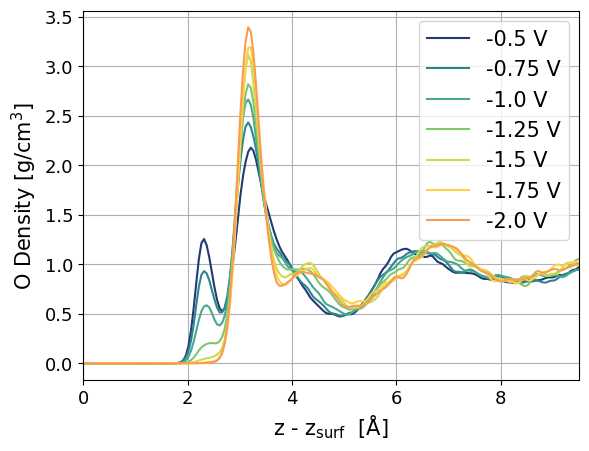

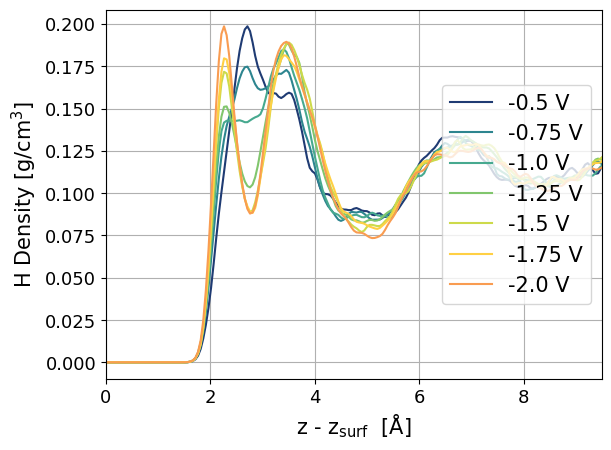

In [6]:
# Plot and save to file the density profile

# Monitoring the convergence of the density profile during the different active learning cycles provide a 
# good indication of the reliability of the ML potential
from workflow_utils.python_utils import compute_solvent_density_profile

#Specify the number of the Active Learning iteration
round = 2
os.chdir('MD')

for V in V_vector_labels:

    print(f"Computing the density profile for case {V}\n")
    bin_center, density_O_g_cm3_kde, density_H_g_cm3_kde = compute_solvent_density_profile(
                                                                                            MD_file=f'{V}/Cu_H2O_NVT_{V}.dump', 
                                                                                            format="lammps-dump-text", 
                                                                                            sigma=0.06, 
                                                                                            z_surf=5.165,
                                                                                            n_bin=200
                                                                                            )
    
    # Save to file the density profile
    os.makedirs(f'results_round_{round}',exist_ok=True)
    np.savetxt(f'results_round_{round}/z_profile_{V}_kde.dat',bin_center)
    np.savetxt(f'results_round_{round}/O_profile_{V}_kde.dat',density_O_g_cm3_kde)
    np.savetxt(f'results_round_{round}/H_profile_{V}_kde.dat',density_H_g_cm3_kde)

# Choose a color palette (e.g., 'fessa_r' has 7 distinct colors)
from fessa_color_palette import fessa
# Get the colormap
cmap = plt.get_cmap('fessa')

# Sample colors from the colormap
palette = [cmap(i / len(V_vector_labels)) for i in range(len(V_vector_labels))]

# Plot the comparison of the O density profiles at different potentials

for V, V_format_number, color in zip(V_vector_labels,V_vector,palette):
    bin_center = np.loadtxt(f'results_round_{round}/z_profile_{V}_kde.dat')
    density_O_g_cm3_kde = np.loadtxt(f'results_round_{round}/O_profile_{V}_kde.dat')
    plt.plot(bin_center, density_O_g_cm3_kde, color=color, label=f'{V_format_number} V')

params = {'mathtext.default': 'regular' } 
plt.rcParams.update(params)
plt.xlabel('z - z$_{surf}$  [$\AA$]',fontsize=15)
plt.ylabel('O Density [g/cm$^{3}$]',fontsize=15)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.grid()
plt.xlim([0,9.5])
plt.legend(fontsize=15)
plt.savefig(f'results_round_{round}/O_density_V_comparison_kde.png',dpi=500)
plt.show()

# Plot the comparison of the H density profiles at different potentials

for V, V_format_number, color in zip(V_vector_labels,V_vector,palette):
    bin_center = np.loadtxt(f'results_round_{round}/z_profile_{V}_kde.dat')
    density_H_g_cm3_kde = np.loadtxt(f'results_round_{round}/H_profile_{V}_kde.dat')
    plt.plot(bin_center, density_H_g_cm3_kde, color=color, label=f'{V_format_number} V')

params = {'mathtext.default': 'regular' } 
plt.rcParams.update(params)
plt.xlabel('z - z$_{surf}$  [$\AA$]',fontsize=15)
plt.ylabel('H Density [g/cm$^{3}$]',fontsize=15)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.grid()
plt.xlim([0,9.5])
plt.legend(fontsize=15,loc='right')
plt.savefig(f'results_round_{round}/H_density_V_comparison_kde.png',dpi=500)
plt.show()

os.chdir('..')

Save trajectories of the MD simulations in xyz format, with energy and forces for the DEAL step

In [10]:
os.chdir('MD')

for V in V_vector_labels:
    print(f"Converting the trajectory to xyz format for case {V}\n")
    traj=read(f'{V}/Cu_H2O_NVT_{V}.dump',format='lammps-dump-text',index=':') # Here geometry and forces are read
    thermo=np.loadtxt(f'{V}/thermo.out',skiprows=1)
    energy=thermo[:,3]  # Assuming the total energy is in the fourth column of thermo.out
    
    for i,snap in enumerate(traj):
        forces=snap.get_forces()
        
        #Remove other info
        snap.calc = None
        snap.info.clear()

        #Set only energy and forces
        snap.set_array("forces",forces)
        snap.info['energy'] = energy[i]
        write(f'{V}/Cu_H2O_NVT_{V}.xyz', snap, format='extxyz',append=True)

os.chdir('..')        

Converting the trajectory to xyz format for case m05

Converting the trajectory to xyz format for case m075

Converting the trajectory to xyz format for case m1

Converting the trajectory to xyz format for case m125

Converting the trajectory to xyz format for case m15

Converting the trajectory to xyz format for case m175

Converting the trajectory to xyz format for case m2



# CHECK
Decide whether to proceed to another active learning iteration or exit from the cycle.

Plot a physical observable (e.g., the O density profile) along the active learning iterations to evaluete convergence.

<>:13: SyntaxWarning: invalid escape sequence '\A'
<>:13: SyntaxWarning: invalid escape sequence '\A'
/scratch_local/ipykernel_3285712/2318607391.py:13: SyntaxWarning: invalid escape sequence '\A'
  plt.xlabel('z - z$_{surf}$  [$\AA$]',fontsize=15)


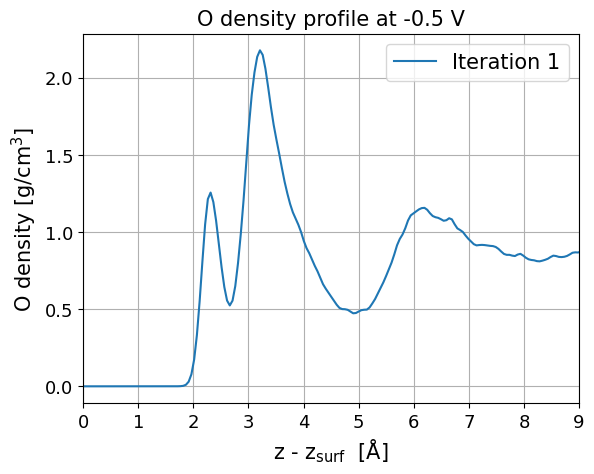

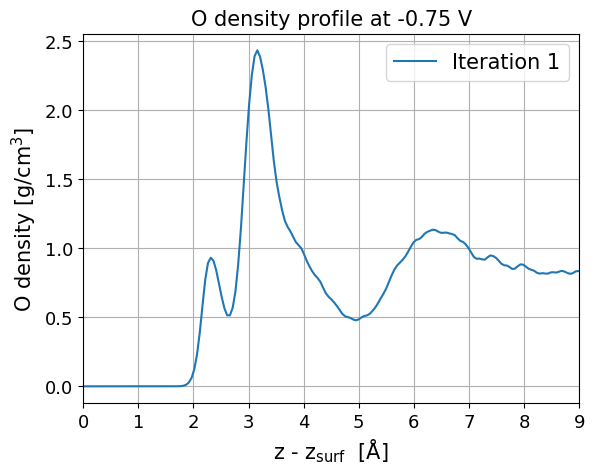

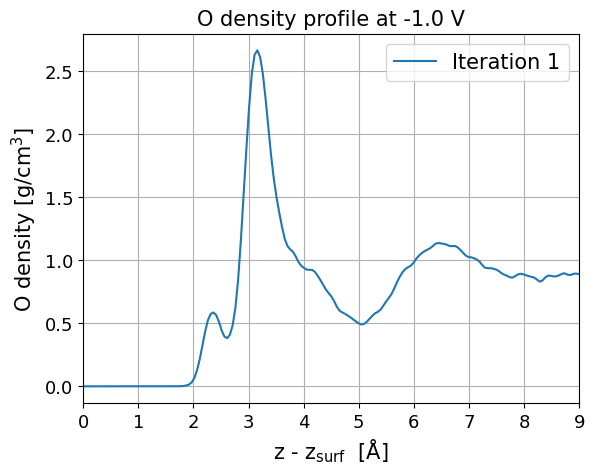

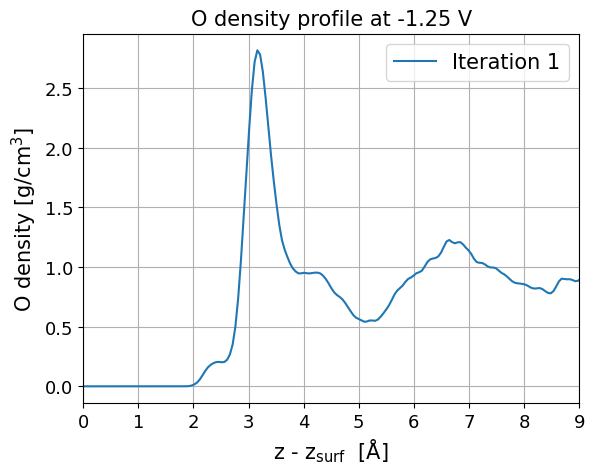

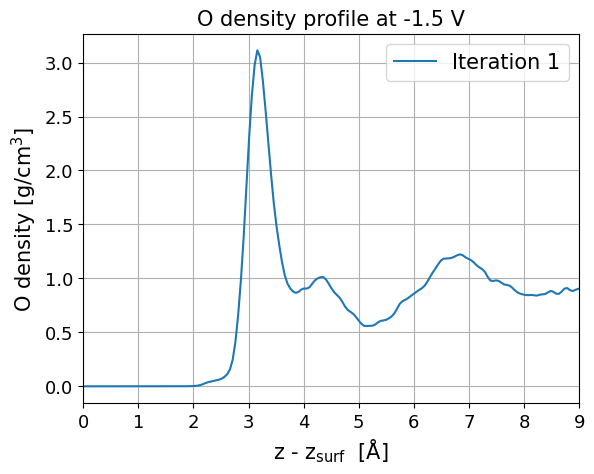

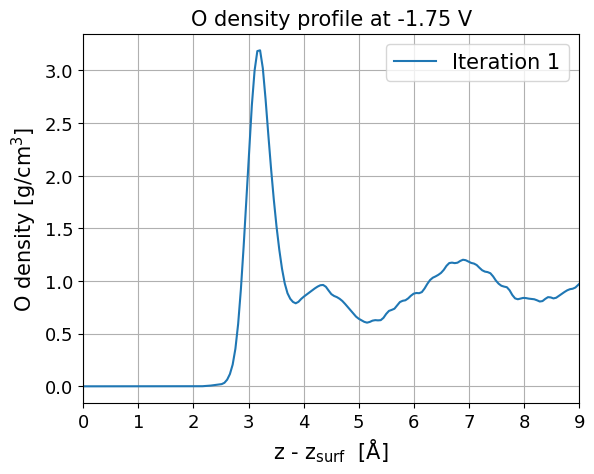

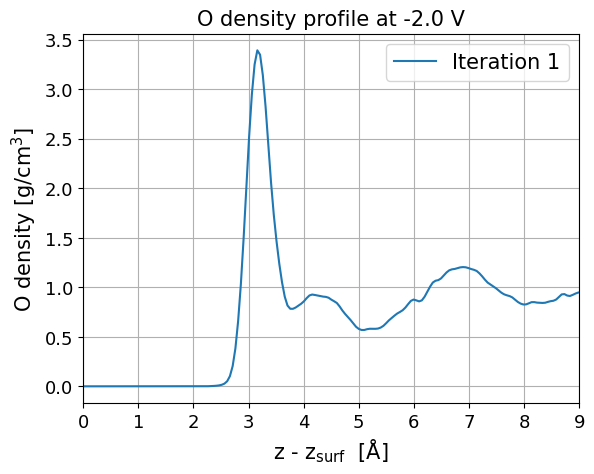

In [11]:
for V, V_format_number, in zip(V_vector_labels,V_vector):
    file_paths = glob.glob("MD/results_round_*")
    counter=0
    for path in natsorted(file_paths):
        z=np.loadtxt(path+f"/z_profile_{V}_kde.dat")
        O=np.loadtxt(path+f"/O_profile_{V}_kde.dat")
        counter=counter+1
        plt.plot(z,O,label=f"Iteration {counter}")

    params = {'mathtext.default': 'regular' } 
    plt.rcParams.update(params)
    plt.title(f'O density profile at {V_format_number} V',fontsize=15)
    plt.xlabel('z - z$_{surf}$  [$\AA$]',fontsize=15)
    plt.ylabel('O density [g/cm$^{3}$]',fontsize=15)
    plt.yticks(fontsize=13)
    plt.xticks(fontsize=13)
    plt.grid()
    plt.xlim([0,9])
    plt.legend(fontsize=15)
    plt.show()

If the density profile remains unchanged during subsequent cycles, you may be satisfied with the resulting model and choose to exit the active learning cycle.

Otherwise continue with the following notebooks of the active learning cycle...